# Practical 5: English to French Translation using Attention Mechanism with TensorFlow

## Prerequisites
## Required Libraries

In [99]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import os
import time
from sklearn.model_selection import train_test_split
import unicodedata

## Installation

In [100]:
!pip install tensorflow>=2.8.0
!pip install numpy pandas matplotlib scikit-learn

## Dataset Preparation

## Download English-French Dataset

In [101]:
import urllib.request
import zipfile
import os

def download_and_extract_dataset():
    """Download English-French dataset from Anki with User-Agent"""
    url = "http://www.manythings.org/anki/fra-eng.zip"
    zip_path = "fra-eng.zip"

    # Create a Request with a User-Agent header
    req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0 (Linux; Android 13; SM-G981B) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Mobile Safari/537.36'})

    # Download dataset
    with urllib.request.urlopen(req) as response, open(zip_path, 'wb') as out_file:
        data = response.read()
        out_file.write(data)

    # Extract dataset
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('.')

    # Clean up
    os.remove(zip_path)
    print("Dataset downloaded and extracted successfully!")

# Uncomment to download
download_and_extract_dataset()

Dataset downloaded and extracted successfully!


## Load Dataset Function

In [102]:
def load_dataset(path='fra.txt', num_examples=50000):
    """Load and prepare the dataset"""
    lines = open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = []
    for line in lines[:num_examples]:
        # Split by tab (format: English\tFrench)
        parts = line.split('\t')
        if len(parts) >= 2:
            word_pairs.append([parts[0], parts[1]])

    return zip(*word_pairs)

## Text Preprocessing

## Text Cleaning and Normalization

In [103]:
def unicode_to_ascii(s):
    """Convert unicode string to ascii"""
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    """Clean and preprocess sentence"""
    w = unicode_to_ascii(w.lower().strip())

    # Add spaces around punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # Replace non-letter characters with space (except punctuation)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # Add start and end tokens
    w = '<start> ' + w + ' <end>'
    return w

def create_dataset(path, num_examples=50000):
    """Create preprocessed dataset"""
    lines = open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = []
    for line in lines[:num_examples]:
        parts = line.split('\t')
        if len(parts) >= 2:
            english = preprocess_sentence(parts[0])
            french = preprocess_sentence(parts[1])
            word_pairs.append([english, french])

    return zip(*word_pairs)

## Tokenization and Vocabulary Creation

In [104]:
class LanguageTokenizer:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.max_length = 0 # Added max_length attribute

    def create_tokenizer(self, dataset):
        """Create tokenizer from dataset"""
        for sentence in dataset:
            words = sentence.split(' ')
            self.max_length = max(self.max_length, len(words)) # Calculate max length
            for word in words:
                if word not in self.vocab:
                    self.vocab.add(word)

        # Sort vocabulary
        self.vocab = sorted(self.vocab)

        # Create word to index mapping
        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        # Create index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word

        return self.word2idx, self.idx2word

    def encode(self, sentence, max_length):
        """Convert sentence to sequence of indices"""
        sequence = [self.word2idx.get(word, 0) for word in sentence.split(' ')]
        sequence = sequence[:max_length]
        sequence += [0] * (max_length - len(sequence))
        return sequence

    def decode(self, sequence):
        """Convert sequence of indices back to sentence"""
        return ' '.join([self.idx2word.get(idx, '<unk>') for idx in sequence if idx != 0])

def create_tokenizers_and_datasets(en_sentences, fr_sentences):
    """Create tokenizers and convert sentences to sequences"""
    # Create tokenizers
    en_tokenizer = LanguageTokenizer()
    fr_tokenizer = LanguageTokenizer()

    en_tokenizer.create_tokenizer(en_sentences)
    fr_tokenizer.create_tokenizer(fr_sentences)

    # Find max length
    en_max_length = en_tokenizer.max_length
    fr_max_length = fr_tokenizer.max_length

    print(f'English max length: {en_max_length}')
    print(f'French max length: {fr_max_length}')
    print(f'English vocab size: {len(en_tokenizer.word2idx)}')
    print(f'French vocab size: {len(fr_tokenizer.word2idx)}')

    # Convert to sequences
    input_tensor = np.array([en_tokenizer.encode(sentence, en_max_length)
                           for sentence in en_sentences])
    target_tensor = np.array([fr_tokenizer.encode(sentence, fr_max_length)
                            for sentence in fr_sentences])

    return input_tensor, target_tensor, en_tokenizer, fr_tokenizer, en_max_length, fr_max_length

## Model Architecture
## Encoder Class

In [105]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units

        # Embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # Bidirectional LSTM
        self.lstm = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(enc_units,
                               return_sequences=True,
                               return_state=True,
                               recurrent_initializer='glorot_uniform'),
            merge_mode='sum'
        )

    def call(self, x, hidden):
        # x shape: (batch_size, max_length)
        x = self.embedding(x)
        # x shape after embedding: (batch_size, max_length, embedding_dim)

        output, forward_h, forward_c, backward_h, backward_c = self.lstm(x, initial_state=hidden)

        # Combine forward and backward states
        state_h = tf.keras.layers.Add()([forward_h, backward_h])
        state_c = tf.keras.layers.Add()([forward_c, backward_c])

        return output, state_h, state_c

    def initialize_hidden_state(self):
        # For bidirectional LSTM, we need states for both directions
        return [tf.zeros((self.batch_size, self.enc_units)) for _ in range(4)]

## Attention Mechanism (Luong Attention)

In [106]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.units = units
        # Attention weight matrix (for 'general' score function)
        self.W = tf.keras.layers.Dense(units)

    def call(self, query, values):
        # query shape: (batch_size, hidden_size)
        # values shape: (batch_size, max_len, hidden_size)

        # Apply linear transformation to values (encoder outputs)
        # values_transformed shape: (batch_size, max_len, units)
        values_transformed = self.W(values)

        # Expand query to match values dimensions for batch matrix multiplication
        # query_with_time_axis shape: (batch_size, 1, hidden_size)
        query_with_time_axis = tf.expand_dims(query, 1)

        # Calculate attention scores using dot product (general score function)
        # score shape: (batch_size, 1, max_len)
        score = tf.matmul(query_with_time_axis, values_transformed, transpose_b=True)

        # Apply softmax to get attention weights
        # attention_weights shape: (batch_size, 1, max_len)
        attention_weights = tf.nn.softmax(score, axis=2)

        # Calculate context vector
        # context_vector shape: (batch_size, 1, hidden_size)
        context_vector = tf.matmul(attention_weights, values)

        # Remove time dimension from context vector and attention weights
        # context_vector shape: (batch_size, hidden_size)
        context_vector = tf.squeeze(context_vector, 1)
        # attention_weights shape: (batch_size, max_len)
        attention_weights = tf.squeeze(attention_weights, 1)


        return context_vector, attention_weights

## Decoder Class

In [107]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size, attention_type='luong'):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.vocab_size = vocab_size

        # Layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        self.attention = LuongAttention(dec_units)

        # Final output layer
        self.Wc = tf.keras.layers.Dense(dec_units, activation='tanh')
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, hidden, enc_output):
        # Debugging print statements
        # print("Decoder input x shape:", x.shape)

        # x shape: (batch_size, 1)
        # hidden shape: (batch_size, dec_units)
        # enc_output shape: (batch_size, max_length, hidden_size)

        # Pass through embedding
        x = self.embedding(x)
        # x shape after embedding: (batch_size, 1, embedding_dim)
        # print("Decoder embedding output shape:", x.shape)


        # Pass through LSTM
        output, state_h, state_c = self.lstm(x, initial_state=hidden)
        # output shape: (batch_size, 1, dec_units)

        # Squeeze the time dimension for attention query
        query = tf.squeeze(output, axis=1) # query shape: (batch_size, dec_units)

        # Calculate attention
        context_vector, attention_weights = self.attention(query, enc_output)
        # context_vector shape: (batch_size, dec_units)
        # attention_weights shape: (batch_size, max_len)

        # Combine context vector and decoder output
        # output shape: (batch_size, 1, dec_units) -> squeeze to (batch_size, dec_units)
        output = tf.concat([context_vector, tf.squeeze(output, 1)], axis=-1)

        # Add time dimension back and apply final transformations
        output = tf.expand_dims(output, 1) # output shape: (batch_size, 1, 2 * dec_units)
        output = self.Wc(output) # output shape: (batch_size, 1, dec_units)
        output = tf.reshape(output, (-1, output.shape[2])) # output shape: (batch_size, dec_units)

        # Final prediction
        x = self.fc(output)

        return x, [state_h, state_c], attention_weights

## Complete Model Class

In [108]:
class EncoderDecoderModel(tf.keras.Model):
    def __init__(self, enc_vocab_size, dec_vocab_size, embedding_dim,
                 enc_units, dec_units, batch_size):
        super(EncoderDecoderModel, self).__init__()

        self.encoder = Encoder(enc_vocab_size, embedding_dim, enc_units, batch_size)
        self.decoder = Decoder(dec_vocab_size, embedding_dim, dec_units, batch_size)

        self.dec_vocab_size = dec_vocab_size

    def call(self, inputs, training=True):
        enc_input, dec_input = inputs

        # Initialize encoder hidden state
        enc_hidden = self.encoder.initialize_hidden_state()

        # Encode
        enc_output, enc_h, enc_c = self.encoder(enc_input, enc_hidden)

        # Initialize decoder hidden state with encoder states
        dec_hidden = [enc_h, enc_c]

        # Decode
        predictions = []
        attention_weights_list = []

        for t in range(dec_input.shape[1]):
            dec_input_t = tf.expand_dims(dec_input[:, t], 1)

            predictions_t, dec_hidden, attention_weights = self.decoder(
                dec_input_t, dec_hidden, enc_output)

            predictions.append(predictions_t)
            attention_weights_list.append(attention_weights)

        # Stack predictions
        predictions = tf.stack(predictions, axis=1)

        return predictions, attention_weights_list

## Training
## Loss Function and Optimizer

In [109]:
def loss_function(real, pred):
    """Custom loss function that ignores padding tokens"""
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

    loss = loss_object(real, pred)

    # Create mask to ignore padding tokens
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss.dtype)

    loss *= mask

    return tf.reduce_mean(loss)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

## Training Step

In [110]:
#@tf.function # Removed tf.function decorator
def train_step(inp, targ, model):
    loss = 0

    with tf.GradientTape() as tape:
        # Teacher forcing - feeding the target as the next input
        dec_input = targ[:, :-1]
        dec_target = targ[:, 1:]

        predictions, attention_weights = model([inp, dec_input], training=True)

        loss = loss_function(dec_target, predictions)

    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)

    # Gradient clipping
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)

    optimizer.apply_gradients(zip(gradients, variables))

    return loss

## Training Loop

In [111]:
def train_model(model, dataset, epochs, steps_per_epoch):
    """Train the model"""

    print("Starting training...")

    for epoch in range(epochs):
        start = time.time()

        total_loss = 0

        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            batch_loss = train_step(inp, targ, model)
            total_loss += batch_loss

            if batch % 100 == 0:
                print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')

        print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
        print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            model.save_weights(f'checkpoints/ckpt-{epoch+1}.weights.h5')
            print(f'Checkpoint saved at epoch {epoch+1}')

## Inference and Translation
## Translation Function

In [112]:
def translate(sentence, model, en_tokenizer, fr_tokenizer, max_length_fr):
    """Translate a sentence from English to French"""

    sentence = preprocess_sentence(sentence)

    inputs = [en_tokenizer.encode(sentence, en_tokenizer.max_length)] # Use encoder max length
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    # Initialize hidden state with batch size 1 for inference
    hidden = [tf.zeros((1, model.encoder.enc_units)) for _ in range(4)]
    enc_out, enc_h, enc_c = model.encoder(inputs, hidden)

    dec_hidden = [enc_h, enc_c]
    dec_input = tf.expand_dims([fr_tokenizer.word2idx['<start>']], 0)

    # Initialize attention_plot with shape based on max possible lengths
    # The size of the attention weights will be (1, max_length_en) during inference
    attention_plot = np.zeros((max_length_fr, en_tokenizer.max_length))


    for t in range(max_length_fr):
        predictions, dec_hidden, attention_weights = model.decoder(
            dec_input, dec_hidden, enc_out)

        # Store attention weights for plotting
        # attention_weights shape: (1, max_len) during inference
        # Reshape to (max_len,) to match the dimension of attention_plot slice
        attention_plot[t] = tf.reshape(attention_weights, (en_tokenizer.max_length,)).numpy()


        predicted_id = tf.argmax(predictions[0]).numpy()

        predicted_token = fr_tokenizer.idx2word.get(predicted_id, '<unk>')
        result += predicted_token + ' '

        if predicted_token == '<end>':
            break

        # The predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result.strip(), sentence, attention_plot

def evaluate_translation(sentence, model, en_tokenizer, fr_tokenizer, max_length_fr):
    """Evaluate a single translation"""
    result, sentence, attention_plot = translate(sentence, model, en_tokenizer,
                                               fr_tokenizer, max_length_fr)

    print(f'Input: {sentence}')
    print(f'Predicted translation: {result}')

    return result, attention_plot

## Evaluation
## BLEU Score Implementation

In [113]:
from collections import Counter
import math

def calculate_bleu_score(reference, candidate, n=4):
    """Calculate BLEU score for a single sentence pair"""
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()

    if len(candidate_tokens) == 0:
        return 0.0

    # Calculate precision for n-grams
    precisions = []

    for i in range(1, n + 1):
        ref_ngrams = Counter([' '.join(reference_tokens[j:j+i])
                             for j in range(len(reference_tokens) - i + 1)])
        cand_ngrams = Counter([' '.join(candidate_tokens[j:j+i])
                              for j in range(len(candidate_tokens) - i + 1)])

        if sum(cand_ngrams.values()) == 0:
            precisions.append(0.0)
            continue

        matches = sum((ref_ngrams & cand_ngrams).values())
        total = sum(cand_ngrams.values())
        precision = matches / total
        precisions.append(precision)

    # Brevity penalty
    bp = 1.0
    if len(candidate_tokens) < len(reference_tokens):
        bp = math.exp(1 - len(reference_tokens) / len(candidate_tokens))

    # Geometric mean of precisions
    if all(p > 0 for p in precisions):
        bleu = bp * math.exp(sum(math.log(p) for p in precisions) / len(precisions))
    else:
        bleu = 0.0

    return bleu * 100  # Convert to percentage

def evaluate_model(model, test_sentences_en, test_sentences_fr,
                  en_tokenizer, fr_tokenizer, max_length_fr):
    """Evaluate model on test set"""
    total_bleu = 0
    num_sentences = len(test_sentences_en)

    for i in range(num_sentences):
        english_sentence = test_sentences_en[i]
        reference_french = test_sentences_fr[i]

        # Remove start and end tokens from reference
        reference_french = reference_french.replace('<start> ', '').replace(' <end>', '')

        # Correctly unpack the three values returned by translate
        predicted_french, _, _ = translate(english_sentence, model, en_tokenizer,
                                      fr_tokenizer, max_length_fr)
        predicted_french = predicted_french.replace('<start> ', '').replace(' <end>', '')

        bleu = calculate_bleu_score(reference_french, predicted_french)
        total_bleu += bleu

        if i < 5:  # Print first 5 examples
            print(f"English: {english_sentence}")
            print(f"Reference: {reference_french}")
            print(f"Predicted: {predicted_french}")
            print(f"BLEU Score: {bleu:.2f}")
            print("-" * 50)

    avg_bleu = total_bleu / num_sentences
    print(f"Average BLEU Score: {avg_bleu:.2f}")
    return avg_bleu

## Visualization
## Attention Visualization

In [114]:
def plot_attention(attention, sentence, predicted_sentence):
    """Plot attention weights"""

    sentence_tokens = sentence.split(' ')
    predicted_tokens = predicted_sentence.split(' ')

    # Remove end token if present in predicted sentence
    if '<end>' in predicted_tokens:
        end_idx = predicted_tokens.index('<end>')
        predicted_tokens = predicted_tokens[:end_idx]
        # Slice attention matrix to match the length of the predicted sentence
        attention = attention[:len(predicted_tokens), :]

    # Slice attention matrix to match the length of the input sentence
    attention = attention[:, :len(sentence_tokens)]

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)

    ax.matshow(attention, cmap='Blues')

    ax.set_xticklabels([''] + sentence_tokens, rotation=90)
    ax.set_yticklabels([''] + predicted_tokens)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.xlabel('English Input')
    plt.ylabel('French Output')
    plt.title('Attention Visualization')

    plt.tight_layout()
    plt.show()

def visualize_attention_for_sentence(sentence, model, en_tokenizer, fr_tokenizer, max_length_fr):
    """Visualize attention for a specific sentence"""
    result, processed_sentence, attention_plot = translate(
        sentence, model, en_tokenizer, fr_tokenizer, max_length_fr)

    print(f'Input: {sentence}')
    print(f'Prediction: {result}')

    plot_attention(attention_plot, processed_sentence, result)

    return result, attention_plot

## Complete Implementation
## Main Training Script

Loading and preprocessing data...
English max length: 8
French max length: 15
English vocab size: 1989
French vocab size: 3685
Training samples: 8000
Validation samples: 2000
Starting training...
Starting training...
Epoch 1 Batch 0 Loss 3.1986
Epoch 1 Batch 100 Loss 1.6528
Epoch 1 Loss 1.7719
Time taken for 1 epoch 72.47 sec

Epoch 2 Batch 0 Loss 1.3684
Epoch 2 Batch 100 Loss 1.3398
Epoch 2 Loss 1.4451
Time taken for 1 epoch 68.00 sec

Epoch 3 Batch 0 Loss 1.3379
Epoch 3 Batch 100 Loss 1.3051
Epoch 3 Loss 1.2592
Time taken for 1 epoch 65.72 sec

Epoch 4 Batch 0 Loss 1.0968
Epoch 4 Batch 100 Loss 1.0960
Epoch 4 Loss 1.1181
Time taken for 1 epoch 65.55 sec

Epoch 5 Batch 0 Loss 1.0662
Epoch 5 Batch 100 Loss 1.0353
Epoch 5 Loss 1.0026
Time taken for 1 epoch 64.67 sec

Checkpoint saved at epoch 5
Epoch 6 Batch 0 Loss 0.9592
Epoch 6 Batch 100 Loss 0.8480
Epoch 6 Loss 0.8960
Time taken for 1 epoch 65.47 sec

Epoch 7 Batch 0 Loss 0.8438
Epoch 7 Batch 100 Loss 0.7372
Epoch 7 Loss 0.8046
Time 

/tmp/ipython-input-201340429.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence_tokens, rotation=90)
/tmp/ipython-input-201340429.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_tokens)


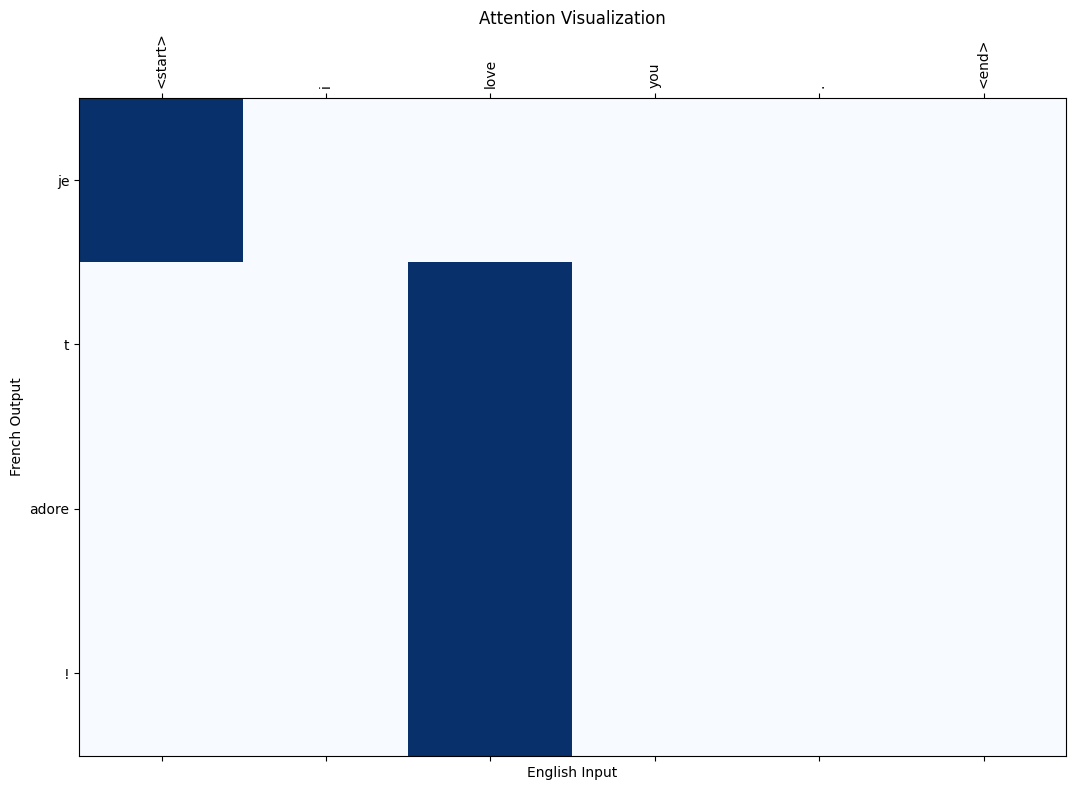


Input: <start> how are you ? <end>
Predicted translation: ca va ? <end>
Input: How are you?
Prediction: ca va ? <end>


/tmp/ipython-input-201340429.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence_tokens, rotation=90)
/tmp/ipython-input-201340429.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_tokens)


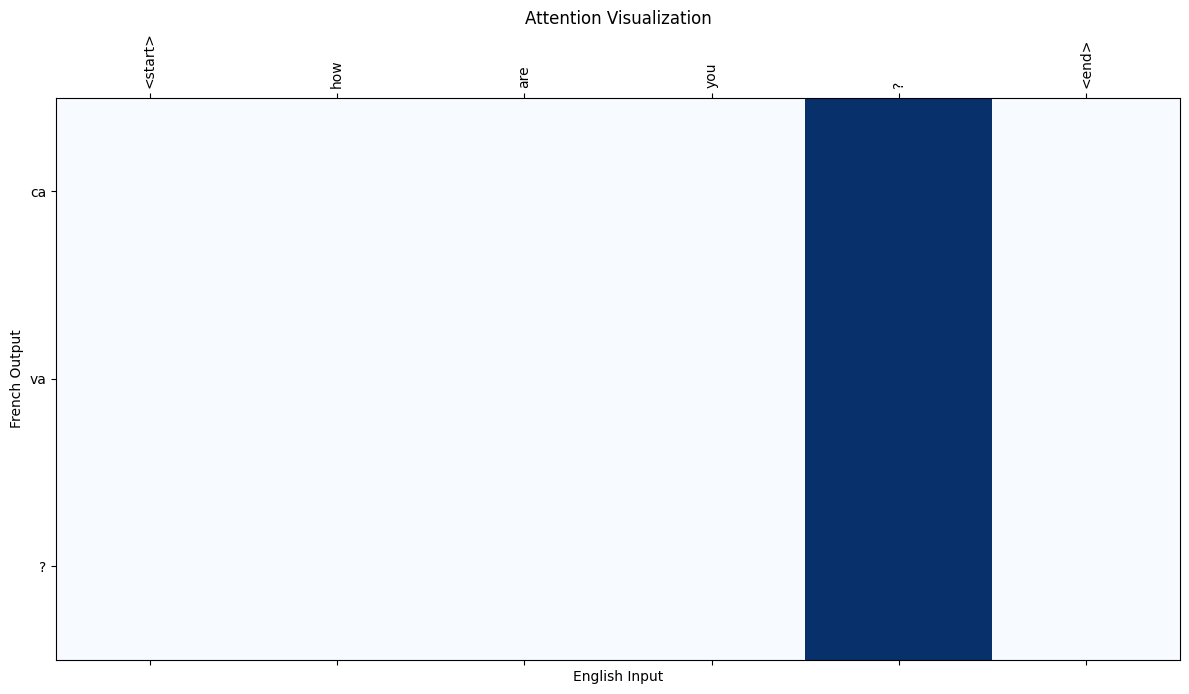


Input: <start> good morning . <end>
Predicted translation: bonjour ! <end>
Input: Good morning.
Prediction: bonjour ! <end>


/tmp/ipython-input-201340429.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence_tokens, rotation=90)
/tmp/ipython-input-201340429.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_tokens)


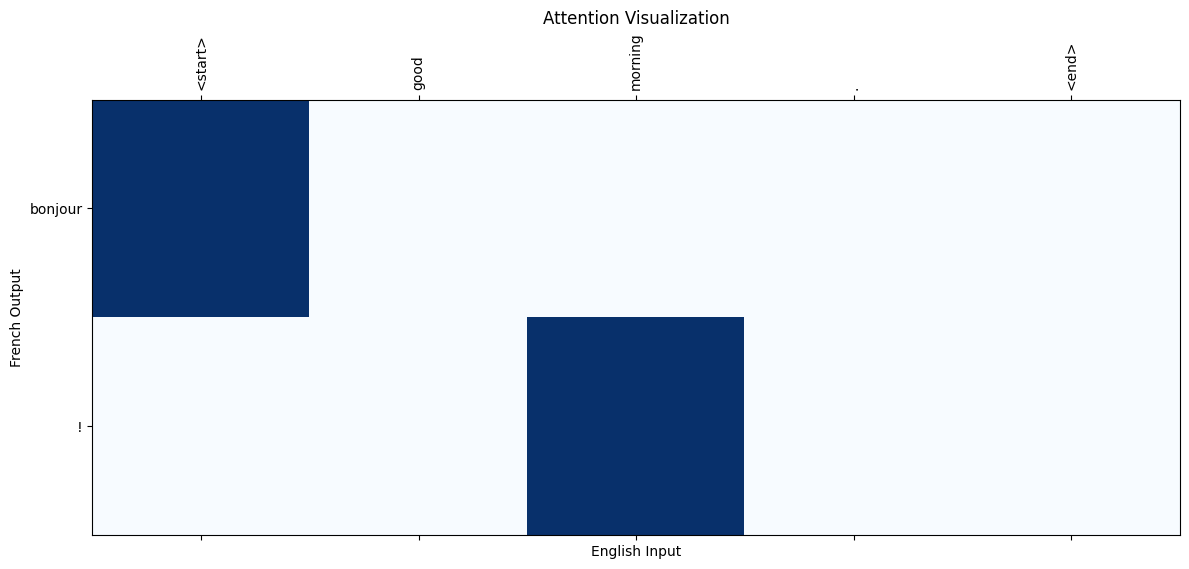


Input: <start> this is a beautiful day . <end>
Predicted translation: c est un bizarre . <end>
Input: This is a beautiful day.
Prediction: c est un bizarre . <end>


/tmp/ipython-input-201340429.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence_tokens, rotation=90)
/tmp/ipython-input-201340429.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_tokens)


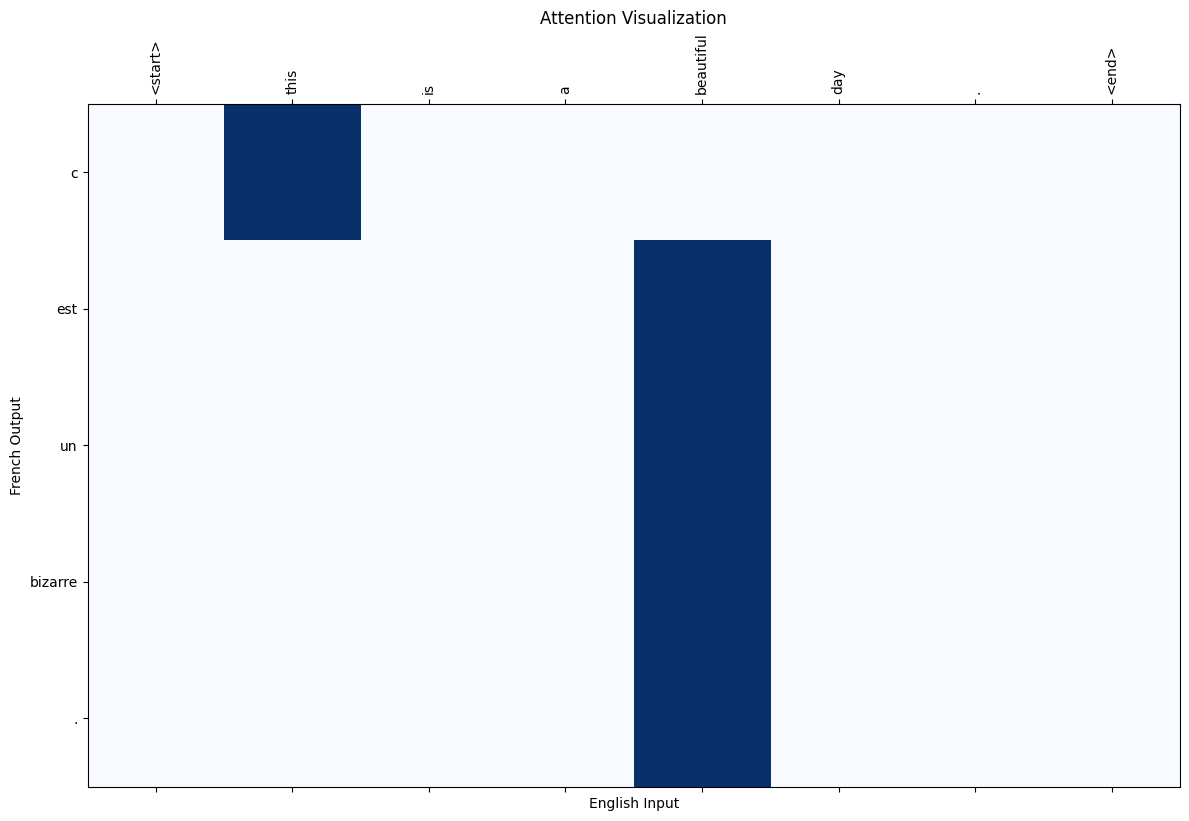


Input: <start> where is the bathroom ? <end>
Predicted translation: ou est ce que tom s est peur ? <end>
Input: Where is the bathroom?
Prediction: ou est ce que tom s est peur ? <end>


/tmp/ipython-input-201340429.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence_tokens, rotation=90)
/tmp/ipython-input-201340429.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_tokens)


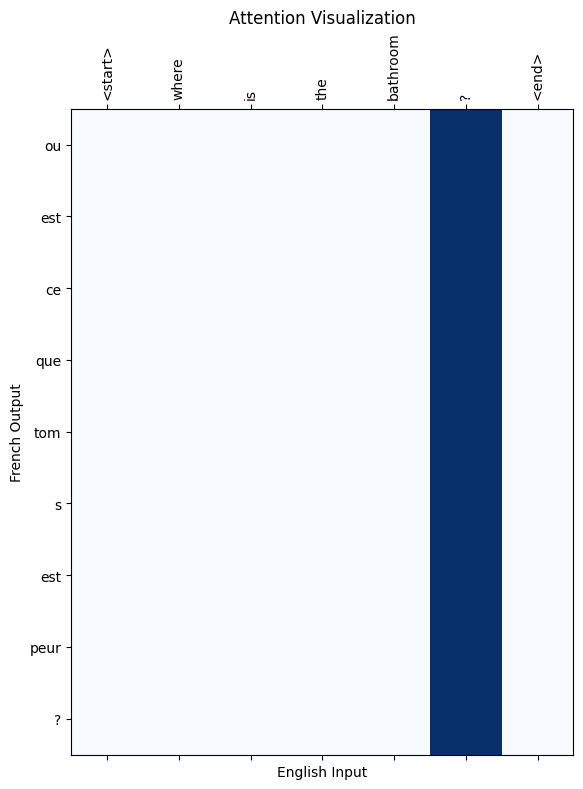



EVALUATING ON VALIDATION SET
English: <start> she is upset . <end>
Reference: elle est perturbee .
Predicted: elle est tres attirante .
BLEU Score: 0.00
--------------------------------------------------
English: <start> you re mean . <end>
Reference: tu es mechante .
Predicted: on etait sourd .
BLEU Score: 0.00
--------------------------------------------------
English: <start> wonderful ! <end>
Reference: genial !
Predicted: c est super .
BLEU Score: 0.00
--------------------------------------------------
English: <start> all was calm . <end>
Reference: le calme regnait .
Predicted: nous sommes facile a l nager .
BLEU Score: 0.00
--------------------------------------------------
English: <start> we re broke . <end>
Reference: nous sommes fauchees .
Predicted: nous sommes fauches .
BLEU Score: 0.00
--------------------------------------------------
Average BLEU Score: 2.00


In [115]:
def main():
    # Hyperparameters
    BATCH_SIZE = 64
    embedding_dim = 256
    units = 512
    # Reduced number of epochs for faster execution
    EPOCHS = 50  # Reduced from 20

    # Create checkpoints directory if it doesn't exist
    if not os.path.exists('checkpoints'):
        os.makedirs('checkpoints')

    print("Loading and preprocessing data...")

    # Load dataset (replace with your dataset path)
    # Reduced number of examples for faster execution
    en, fr = create_dataset('fra.txt', num_examples=10000) # Reduced from 30000

    # Create tokenizers and datasets
    input_tensor, target_tensor, en_tokenizer, fr_tokenizer, max_length_en, max_length_fr = create_tokenizers_and_datasets(en, fr)

    # Split dataset
    input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
        input_tensor, target_tensor, test_size=0.2, random_state=42)

    print(f"Training samples: {len(input_tensor_train)}")
    print(f"Validation samples: {len(input_tensor_val)}")

    # Create tf.data.Dataset
    BUFFER_SIZE = len(input_tensor_train)
    steps_per_epoch = len(input_tensor_train) // BATCH_SIZE

    dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

    # Initialize model
    model = EncoderDecoderModel(
        enc_vocab_size=len(en_tokenizer.word2idx),
        dec_vocab_size=len(fr_tokenizer.word2idx),
        embedding_dim=embedding_dim,
        enc_units=units,
        dec_units=units,
        batch_size=BATCH_SIZE
    )

    # Build the model by passing a sample batch
    for inp_batch, targ_batch in dataset.take(1):
        _ = model([inp_batch, targ_batch[:, :-1]]) # Pass through the model to build it
        break

    # Re-initialize the optimizer after the model is built
    global optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    print("Starting training...")

    # Train model
    train_model(model, dataset, EPOCHS, steps_per_epoch)

    # Save final model
    model.save_weights('checkpoints/final_model.weights.h5')
    print("Training completed and model saved!")

    # Test translation
    test_sentences = [
        "I love you.",
        "How are you?",
        "Good morning.",
        "This is a beautiful day.",
        "Where is the bathroom?"
    ]

    print("\n" + "="*50)
    print("TESTING TRANSLATIONS")
    print("="*50)

    for sentence in test_sentences:
        result, attention_plot = evaluate_translation(sentence, model, en_tokenizer, fr_tokenizer, max_length_fr)
        visualize_attention_for_sentence(sentence, model, en_tokenizer, fr_tokenizer, max_length_fr)
        print()

    # Evaluate on validation set
    print("\n" + "="*50)
    print("EVALUATING ON VALIDATION SET")
    print("="*50)

    # Convert validation tensors back to sentences for BLEU evaluation
    val_en_sentences = [en_tokenizer.decode(seq) for seq in input_tensor_val[:100]]
    val_fr_sentences = [fr_tokenizer.decode(seq) for seq in target_tensor_val[:100]]

    avg_bleu = evaluate_model(model, val_en_sentences, val_fr_sentences,
                            en_tokenizer, fr_tokenizer, max_length_fr)

if __name__ == "__main__":
    main()